# iForest

In [1]:
import warnings
warnings.filterwarnings('ignore')

## General libraries

In [2]:
import os
import sys

import pandas as pd
import numpy as np

from os.path import join
import json
import datetime

import shap
from shap_selection import feature_selection

from sklearn.preprocessing import OneHotEncoder
import time

### Load enviroment variables

In [3]:
from dotenv import load_dotenv
load_dotenv('../.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

### Specific libraries

In [4]:
from src.load.functions import get_fs_dataset, fs_datasets_hyperparams
from src.model.functions import train_and_evaluate_iforest
from src.utils.functions import adjust_fi

## General parameters

In [5]:
n_iter_fs = 1
n_iter = 1
contamination_percentage = [1]
#trees = [1, 5, 25, 50, 75, 100, 125, 150, 175, 200]

trees = [100]

## Data-set

In [6]:
dataset_id = 'mammography'
data = get_fs_dataset(dataset_id, data_root)
hyper = fs_datasets_hyperparams(dataset_id)
data.shape

(11183, 7)

In [7]:
excluded_cols = []

### iForest

## Parameters

In [8]:
path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")

fi_shap_all = pd.read_parquet(path_fi_shap)
fi_shap_all = adjust_fi(fi_shap_all)

## Model training with iterations HPO and FS

In [9]:
# Capture the start time
start_time = datetime.datetime.now()

df = train_and_evaluate_iforest(data, dataset_id=dataset_id, hyper=hyper, fi_df=fi_shap_all, excluded_cols=excluded_cols, n_iter_fs=n_iter_fs, n_iter=n_iter)

# Capture the finish time
finish_time = datetime.datetime.now()

# Calculate the duration
duration = finish_time - start_time

print(f"Duration: {duration}")

Iteration by tree number: 100
  Iteration by contamination: 0.1
    Number of featured: 2
     Iteration by feat number: 2
    Number of featured: 3
     Iteration by feat number: 2
     Iteration by feat number: 3
    Number of featured: 4
     Iteration by feat number: 2
     Iteration by feat number: 3
     Iteration by feat number: 4
    Number of featured: 5
     Iteration by feat number: 2
     Iteration by feat number: 3
     Iteration by feat number: 4
     Iteration by feat number: 5
    Number of featured: 6
     Iteration by feat number: 2
     Iteration by feat number: 3
     Iteration by feat number: 4
     Iteration by feat number: 6
Duration: 0:02:04.391138


In [10]:
df_save = df.copy()

In [11]:
df = df_save.copy()

In [12]:
df = df.drop(columns=['stab_model_list', 'stab_shap_list'])

In [13]:
df.to_parquet(path_shap)

In [14]:
def process_data(df):
    """
    Processes SHAP data files by reading them, filtering, and calculating additional metrics.
    
    Parameters:
    - dataset_id: The unique identifier for the dataset.
    - data_root: The root directory where the data files are located.
    
    Returns:
    - df: The processed pandas DataFrame containing selected variables and calculated metrics.
    """
    # Calculate percentiles and stability index
    df['shap_q1'] = df['stab_shap'].apply(lambda x: np.percentile(x, 75))
    df['shap_q2'] = df['stab_shap'].apply(lambda x: np.percentile(x, 50))
    df['shap_q3'] = df['stab_shap'].apply(lambda x: np.percentile(x, 25))
    df['stability index'] = df['stab_shap'].apply(lambda x: np.mean(x))

    return df

In [15]:
test = process_data(df)
test = test[(test.n_estimators==100) & (test.n_feats==test.n_feats.max()) & (test.max_feats==test.max_feats.max())]
test

,f1-score,recall,precision,roc_auc,stab_model,stab_shap,n_estimators,max_feats,contamination,n_feats,n_iter,n_iter_fs,shap_q1,shap_q2,shap_q3,stability index
13,0.227523,0.596154,0.14059,0.870685,1.0,"[0.26441537372380547, 0.2988022157911061, 0.07...",100,6,0.1,6,1,1,0.180644,0.09175,0.07958,0.138931


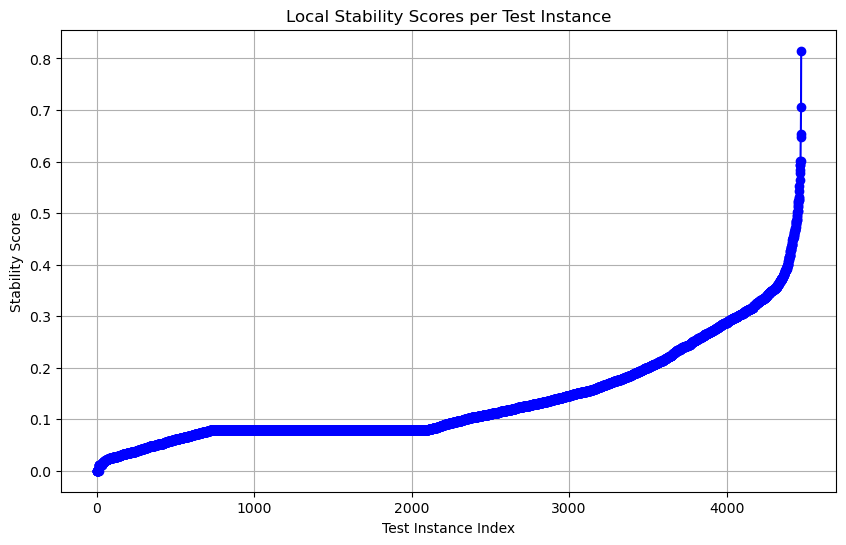

In [16]:
import matplotlib.pyplot as plt

# Assuming `final_stability_score` is your array of stability scores from the modified function
stability_scores = np.array(test.stab_shap)[0]
stability_scores = np.sort(stability_scores)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(stability_scores, marker='o', linestyle='-', color='blue')
plt.title('Local Stability Scores per Test Instance')
plt.xlabel('Test Instance Index')
plt.ylabel('Stability Score')
plt.grid(True)
plt.show()